# Introduction to Business Analytics Project

In [ ]:
import pandas as pd
import numpy as np
import math

#from tqdm import tqdm

import pickle

import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go


import osmnx as ox
import holidays
from haversine import haversine, Unit
import shapely.geometry

from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, pairwise_distances_argmin_min, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC

# Dissable warnings
import warnings
warnings.filterwarnings('ignore')

# Setting seeds
np.random.seed(42)

# 1 Introduction

# 2 Data analysis and visualization

In [11]:
# Loading the dataset 
#data = pd.read_csv('Trips_2018.csv')
data = pd.read_csv('/Users/sofiehultengren/Desktop/Skrivebord – MacBook Pro tilhørende Sofie/Uni/Kandidat /3. semester/42577 Business analytics/Assignment/Trips_2018.csv')

observations = data.shape[0]
attributes = data.shape[1]
print(f"Size of the dataset: {data.shape}")
print("Data snippet:")
data.head()

Size of the dataset: (17548339, 14)
Data snippet:


,Unnamed: 0,tripduration,starttime,stoptime,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender
0,0,970,2018-01-01 13:50:57.4340,2018-01-01 14:07:08.1860,72.0,40.767272,-73.993929,505.0,40.749013,-73.988484,31956,Subscriber,1992,1
1,1,723,2018-01-01 15:33:30.1820,2018-01-01 15:45:33.3410,72.0,40.767272,-73.993929,3255.0,40.750585,-73.994685,32536,Subscriber,1969,1
2,2,496,2018-01-01 15:39:18.3370,2018-01-01 15:47:35.1720,72.0,40.767272,-73.993929,525.0,40.755942,-74.002116,16069,Subscriber,1956,1
3,3,306,2018-01-01 15:40:13.3720,2018-01-01 15:45:20.1910,72.0,40.767272,-73.993929,447.0,40.763707,-73.985162,31781,Subscriber,1974,1
4,4,306,2018-01-01 18:14:51.5680,2018-01-01 18:19:57.6420,72.0,40.767272,-73.993929,3356.0,40.774667,-73.984706,30319,Subscriber,1992,1


As we can see, the dataset consists of 17,548,339 observations across 14 attributes. It includes key information about each bike trip, such as the start and end station IDs, trip duration, and the geographic coordinates (latitude and longitude) of the stations. Additionally, the dataset contains user-related information, including user type, birth year, and gender.

As part of the data preparation, all columns containing NaN values were removed from the dataset. Furthermore, both the start time and stop time variables were converted to datetime format. The “Unnamed” column, which served as an index column, was also removed.

In [12]:
# Dropping unnamed column
data.drop(["Unnamed: 0"], axis=1, inplace=True)

# Removing NaN-values
data.dropna(inplace=True) 

# Converting times and dates to datetime format
data['starttime'] = pd.to_datetime(data['starttime'])
data['stoptime'] = pd.to_datetime(data['stoptime'])
data['date'] = data['starttime'].dt.date


print(f"Size of the dataset: {data.shape}")
print(f"Removed {observations-data.shape[0]} NaN-values")
print("Data snippet:")
data.head()

Size of the dataset: (17545842, 14)
Removed 2497 NaN-values
Data snippet:


,tripduration,starttime,stoptime,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender,date
0,970,2018-01-01 13:50:57.434,2018-01-01 14:07:08.186,72.0,40.767272,-73.993929,505.0,40.749013,-73.988484,31956,Subscriber,1992,1,2018-01-01
1,723,2018-01-01 15:33:30.182,2018-01-01 15:45:33.341,72.0,40.767272,-73.993929,3255.0,40.750585,-73.994685,32536,Subscriber,1969,1,2018-01-01
2,496,2018-01-01 15:39:18.337,2018-01-01 15:47:35.172,72.0,40.767272,-73.993929,525.0,40.755942,-74.002116,16069,Subscriber,1956,1,2018-01-01
3,306,2018-01-01 15:40:13.372,2018-01-01 15:45:20.191,72.0,40.767272,-73.993929,447.0,40.763707,-73.985162,31781,Subscriber,1974,1,2018-01-01
4,306,2018-01-01 18:14:51.568,2018-01-01 18:19:57.642,72.0,40.767272,-73.993929,3356.0,40.774667,-73.984706,30319,Subscriber,1992,1,2018-01-01


To bether understand the data - user analisys was apllied. looking into when the usage of the bikes was at it highest, as weel as how long the durations of the bikes usally where. 

The tripdurations where investigated for the data 

In [13]:
# Statistics of tripduration
print(f"""
Trip duration statistics (sec.):
Trip duration range (sec.): [{min(data['tripduration']):.2f}, {max(data['tripduration']):.2f}] 
Mean: {data['tripduration'].mean():.2f}
Median: {data['tripduration'].median():.2f}
STD:  {data['tripduration'].std():.2f}""")


Trip duration statistics (sec.):
Trip duration range (sec.): [61.00, 19510049.00] 
Mean: 988.47
Median: 605.00
STD:  18895.91


Based on this we can see that the maximum tripduration is much larger than both the mean and the median. This indicates that we have som kind of ourliers. 

To visualise the outliers, the histogram of the duration was plotted on poth linear and log axes

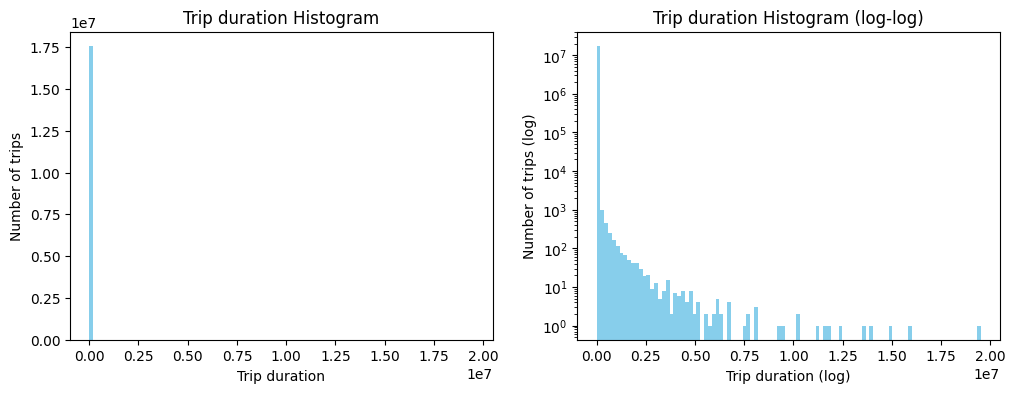

In [14]:
# Plotting the trip duration histogram on linear and log-log axes
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.hist(data['tripduration'], bins=100, color='skyblue')
plt.xlabel('Trip duration')
plt.ylabel('Number of trips')
plt.title('Trip duration Histogram')

plt.subplot(122)
plt.hist(data['tripduration'], bins=100, log=True, color='skyblue')
plt.xlabel('Trip duration (log)')
plt.ylabel('Number of trips (log)')
plt.title('Trip duration Histogram (log-log)')
plt.show()

To improve the quality of the data, outliers were removed. Outliers were defined as trips with a duration above the 99th percentile.

In [15]:
#Removing outliers
data_wo_outliers = data[data['tripduration'] <= data['tripduration'].quantile(0.99)]
print(f"""Number of observations removed as outliers:", {data.shape[0] - data_wo_outliers.shape[0]})
Size of the dataset after removing outliers: {data_wo_outliers.shape}
Trip duration range (sec.) after removing outliers: [{min(data_wo_outliers['tripduration']):.2f}, {max(data_wo_outliers['tripduration']):.2f}]
Mean after removing outliers: {data_wo_outliers['tripduration'].mean():.2f}
Median after removing outliers: {data_wo_outliers['tripduration'].median():.2f}
STD after removing outliers:  {data_wo_outliers['tripduration'].std():.2f}
""")
print()

Number of observations removed as outliers:", 175403)
Size of the dataset after removing outliers: (17370439, 14)
Trip duration range (sec.) after removing outliers: [61.00, 3505.00]
Mean after removing outliers: 776.67
Median after removing outliers: 599.00
STD after removing outliers:  576.04




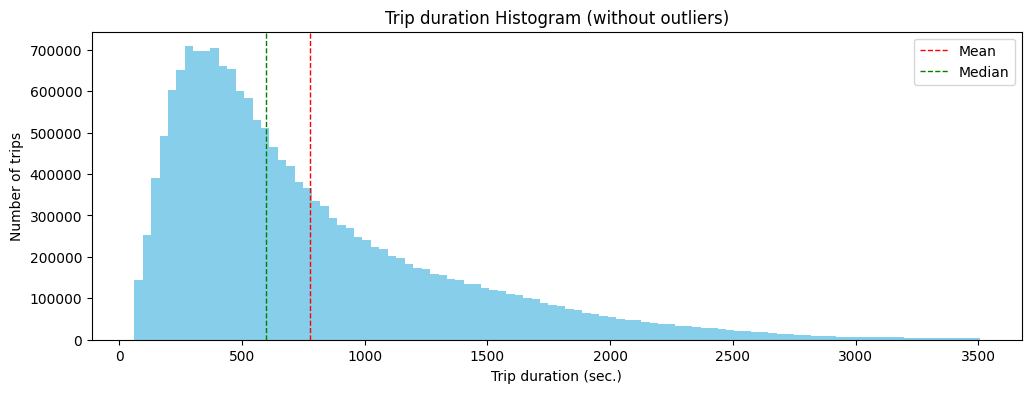

In [16]:
# Visualisng the histogram of the data without outliers 
plt.figure(figsize=(12, 4))
plt.hist(data_wo_outliers['tripduration'], bins=100, color='skyblue')
plt.xlabel('Trip duration (sec.)')
plt.ylabel('Number of trips')
plt.title('Trip duration Histogram (without outliers)')
plt.axvline(data_wo_outliers['tripduration'].mean(), color='red', linestyle='dashed', linewidth=1, label='Mean')
plt.axvline(data_wo_outliers['tripduration'].median(), color='green', linestyle='dashed', linewidth=1, label='Median')
plt.legend()    
plt.show()


The histogram above shows the distribution of trip durations (in seconds) after removing extreme outliers from the dataset. The shape of the distribution is clearly right-skewed, meaning that most trips are relatively short, while a smaller number of trips take significantly longer.

Two vertical dashed lines are included for reference:

- Red dashed line: Mean trip duration  
- Green dashed line: Median trip duration  

Because the mean lies further to the right than the median, this confirms the right-skewness of the data.  
After removing outliers, the distribution becomes smoother and more interpretable, making it easier to understand the typical trip duration and the spread of the data.

## Usage patterns 
To better understand how the bikes are used, we analyze the usage across different time scales: **monthly**, **weekly**, and **daily**.  
The goal is to identify whether there are any clear patterns or tendencies in the data.
By breaking the usage down by these time dimensions, we can gain insights into seasonal trends, weekday vs. weekend behavior, and typical daily usage peaks.


In [36]:
#Creating pickups dataframe
pickups = data_wo_outliers['starttime'].value_counts().reset_index()
pickups.columns = ['time', 'pickups']
pickups = pickups.set_index('time')
pickups.sort_index(inplace=True)

display(pickups.head()) 

# creating dropoff dataframe
dropoffs = data_wo_outliers['stoptime'].value_counts().reset_index()
dropoffs.columns = ['time', 'dropoffs']
dropoffs = dropoffs.set_index('time')
dropoffs.sort_index(inplace=True)
display(dropoffs.head()) 

# Merge dropoffs and pickups on index
pickups_and_dropoffs = pickups.merge(dropoffs, left_index=True, right_index=True, how='outer')
pickups_and_dropoffs = pickups_and_dropoffs.fillna(0)

# Adding weekdays and months to dataframe 
pickups_and_dropoffs['weekday'] = [d.weekday() for d in pickups_and_dropoffs.index]
pickups_and_dropoffs['month'] = [d.month for d in pickups_and_dropoffs.index]

# Sanity check:
print(f"""
Total amount of pickups = Total amount of dropoffs: {pickups['pickups'].sum()==dropoffs['dropoffs'].sum()}""")

,pickups
time,
2018-01-01 00:01:50.650,1
2018-01-01 00:02:43.918,1
2018-01-01 00:03:15.116,1
2018-01-01 00:06:43.709,1
2018-01-01 00:06:56.924,1


,dropoffs
time,
2018-01-01 00:05:07.438,1
2018-01-01 00:06:11.383,1
2018-01-01 00:12:59.450,1
2018-01-01 00:13:28.480,1
2018-01-01 00:13:39.792,1



Total amount of pickups = Total amount of dropoffs: True


Plotting the pickups and droppoff count for each month, to see if there are any months in the dataset where the bikes are used more frequently 

In [38]:
# Plotting the pickups and dropoff counts for each month
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'Oktober', 'November', 'December']
pickups_and_dropoffs_months = [pickups_and_dropoffs[pickups_and_dropoffs['month'] == i+1]['pickups'].sum() for i, month in enumerate(months)]

fig = go.Figure(data=[go.Bar(x=months, y=pickups_and_dropoffs_months, marker_color='skyblue')])
fig.update_layout(xaxis_title="Months", yaxis_title="Total Pickups", title="Monthly Pickups", title_x=0.5, width=900,  height=400)
fig.show()

From the plot above, we can see that bike usage is significantly higher during the warmer months of the year.  
Trips increase steadily from early spring and peak during the summer, indicating that good weather has a strong positive impact on bike demand.

Interestingly, the summer holiday period does not appear to reduce the number of trips.  
Instead, usage remains consistently high throughout June, July, and August, suggesting that the bikes are used frequently even when people might be on vacation.


In [ ]:
# Plotting the pickups and dropoff counts for each weekday
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
pickups_and_dropoffs_weekdays = [pickups_and_dropoffs[pickups_and_dropoffs['weekday'] == i]['pickups'].sum() for i, day in enumerate(days)]

fig = go.Figure(data=[go.Bar(x=days, y=pickups_and_dropoffs_weekdays, marker_color='skyblue')])
fig.update_layout(xaxis_title="Weekdays", yaxis_title="Total Pickups", title="Weekly Pickups", title_x=0.5, width=900,  height=400)
fig.show()

When examining the weekly distribution of bike usage, we see that the number of trips is noticeably higher on weekdays compared to weekends.  
This pattern suggests that a large share of the trips are likely related to commuting or other routine weekday activities.

To further investigate this trend, we also look at how bike usage is distributed throughout the day.  
By analyzing the hourly patterns, we can determine whether there are clear morning and afternoon peaks consistent with typical commuting behaviour.


In [41]:
# Plotting the pickups in hourly intervals for every day of the week
fig = go.Figure()
for i, weekday in enumerate(days):
    weekdata = pickups_and_dropoffs[pickups_and_dropoffs['weekday'] == i]
    grouped_data = weekdata.groupby(weekdata.index.hour).sum()[["pickups", "dropoffs"]]


    index = grouped_data.index
    pickups = grouped_data['pickups']
    fig.add_trace(go.Scatter(x=index, y=pickups, mode='lines', name=f'{weekday}'))

fig.update_layout(title='Number of trips pr hour of the day', xaxis_title='Hour of day', yaxis_title='Number of trips', title_x=0.5, width=900,  height=400)

for time in [7, 9, 16, 19]:
    fig.add_shape(type="line", x0=time, y0=0, x1=time, y1=300000, line=dict(color="RoyalBlue", width=1, dash="dot"))
fig.show()

From the hourly distribution, we observe two very clear peaks in bike usage, one between 7:00–9:00 and another between 16:00–19:00.  
These peaks align closely with typical morning and afternoon commuting hours.

This strongly suggests that many users rely on the bikes for traveling to and from work or school.  
In contrast, the usage outside these time windows is noticeably lower, supporting the interpretation that commuting is a dominant driver of bike demand on weekdays.


# 3 Clustering 

To do clustering we need to only look at the unique stations ID's and both the longitude and latitude variables, so first we extract those, and plot the data. 

In [65]:
stations = (
    data_wo_outliers[['start_station_id', 'start_station_latitude', 'start_station_longitude', 'end_station_id', 'end_station_latitude', 'end_station_longitude']]
    .drop_duplicates(subset='start_station_id')
)

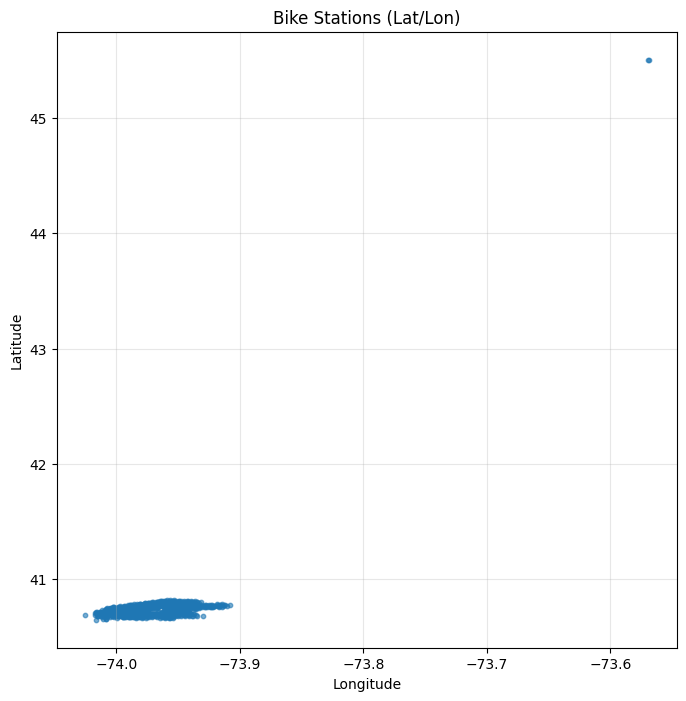

In [66]:

plt.figure(figsize=(8, 8))
plt.scatter(
    stations['start_station_longitude'], 
    stations['start_station_latitude'], 
    s=10, 
    alpha=0.6
)

plt.title("Bike Stations (Lat/Lon)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True, alpha=0.3)

plt.show()

We can clearly see an outlier in the top right corner which we will need to remove

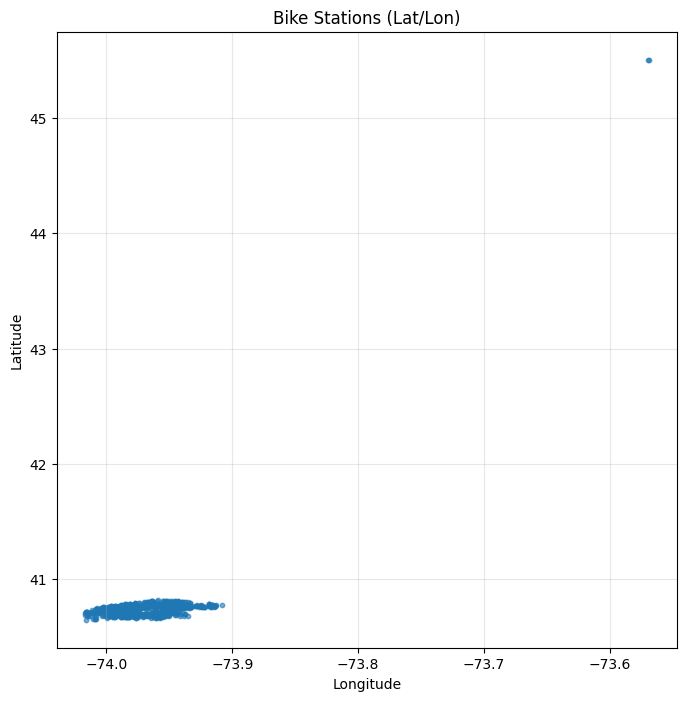

In [93]:

plt.figure(figsize=(8, 8))
plt.scatter(
    stations['end_station_longitude'], 
    stations['end_station_latitude'], 
    s=10, 
    alpha=0.6
)

plt.title("Bike Stations (Lat/Lon)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True, alpha=0.3)

plt.show()

In [96]:
# Remove outlier

stations_clean = stations[
    (stations['start_station_latitude'].between(40.5, 45.9)) &
    (stations['start_station_longitude'].between(-76, -73.6))
].copy()

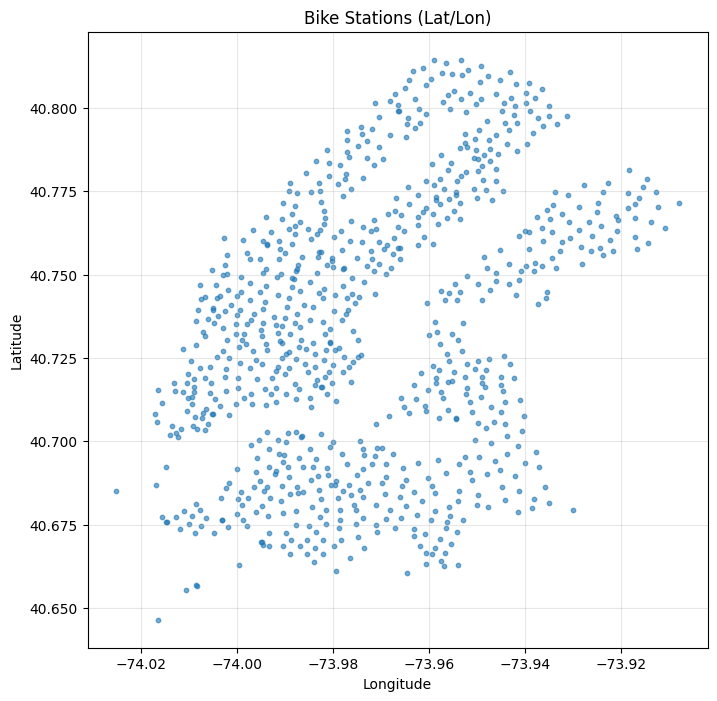

In [89]:
plt.figure(figsize=(8, 8))
plt.scatter(
    stations_clean['start_station_longitude'], 
    stations_clean['start_station_latitude'], 
    s=10, 
    alpha=0.6
)

plt.title("Bike Stations (Lat/Lon)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True, alpha=0.3)

plt.show()

Now the plot looks much better! Next we will do a k-means clustering with 35 clusters.

In [90]:


# 3) Run K-means
coords = stations_clean[['start_station_latitude', 'start_station_longitude']]
kmeans = KMeans(n_clusters=20, random_state=42)
stations_clean['cluster'] = kmeans.fit_predict(coords)

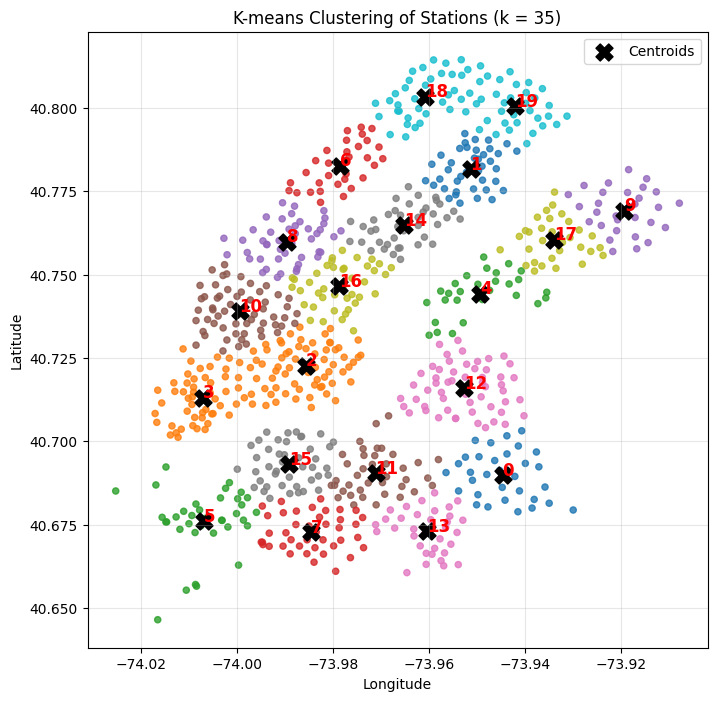

In [91]:


plt.figure(figsize=(8, 8))
plt.scatter(
    stations_clean['start_station_longitude'],
    stations_clean['start_station_latitude'],
    c=stations_clean['cluster'],
    cmap='tab10',
    s=20,
    alpha=0.8
)

# Add cluster centers
centers = kmeans.cluster_centers_
plt.scatter(
    centers[:, 1], centers[:, 0],
    c='black', s=150, marker='X', label='Centroids'
)

# Add centroid labels
for i, (lat, lon) in enumerate(centers):
    plt.text(
        lon, lat,
        str(i),
        fontsize=12,
        fontweight='bold',
        color='red'
    )

plt.title("K-means Clustering of Stations (k = 35)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


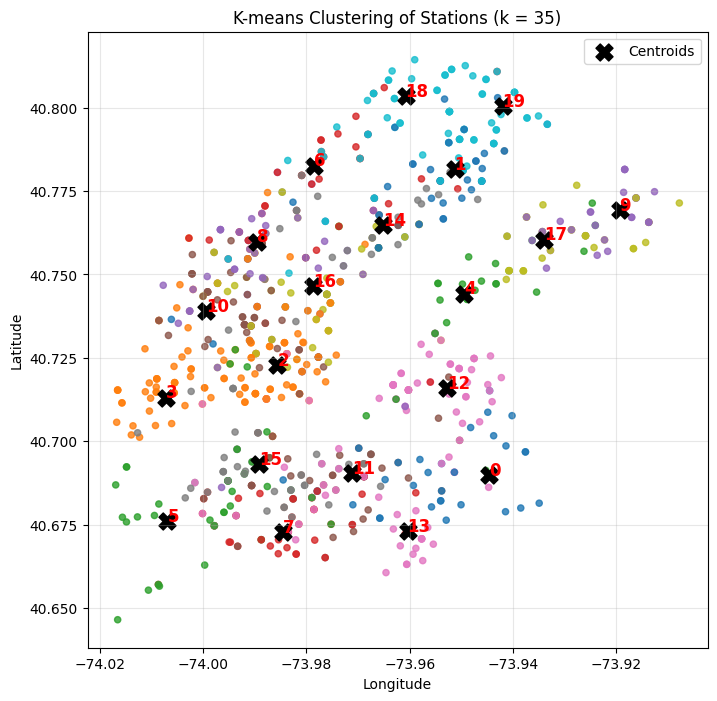

In [92]:

plt.figure(figsize=(8, 8))
plt.scatter(
    stations_clean['end_station_longitude'],
    stations_clean['end_station_latitude'],
    c=stations_clean['cluster'],
    cmap='tab10',
    s=20,
    alpha=0.8
)

# Add cluster centers
centers = kmeans.cluster_centers_
plt.scatter(
    centers[:, 1], centers[:, 0],
    c='black', s=150, marker='X', label='Centroids'
)

# Add centroid labels
for i, (lat, lon) in enumerate(centers):
    plt.text(
        lon, lat,
        str(i),
        fontsize=12,
        fontweight='bold',
        color='red'
    )

plt.title("K-means Clustering of Stations (k = 35)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


Lastly we will add a column that links each station to the corresponding cluster

In [71]:
# Create a dictionary mapping
station_to_cluster = (
    stations_clean
    .set_index('start_station_id')['cluster']
    .to_dict()
)

# Map cluster ID back to the full dataset
data_wo_outliers['start_station_cluster'] = data_wo_outliers['start_station_id'].map(station_to_cluster)

# Create a dictionary mapping
station_to_cluster_end = (
    stations_clean
    .set_index('end_station_id')['cluster']
    .to_dict()
)

station_to_cluster_end
# Map cluster ID back to the full dataset
data_wo_outliers['start_station_cluster'] = data_wo_outliers['start_station_id'].map(station_to_cluster)
data_wo_outliers['end_station_cluster'] = data_wo_outliers['end_station_id'].map(station_to_cluster_end)



# 4 Predictive Model

Mapping stations to cluster

Departures per cluster per hour

In [75]:
data_wo_outliers['hour_dep'] = data_wo_outliers['starttime'].dt.hour
hourly_dep = (
    data_wo_outliers.groupby(['start_station_cluster', 'hour_dep'])
        .size()
        .reset_index(name='pickups')
)
display(hourly_dep.head())

display(data_wo_outliers['hour_dep'].unique())

,start_station_cluster,hour_dep,pickups
0,0.0,0,1386
1,0.0,1,909
2,0.0,2,567
3,0.0,3,382
4,0.0,4,333


array([13, 15, 18, 21,  7,  8,  9, 10, 11, 12, 14, 16, 17, 19, 20, 22,  0,
        6,  5, 23,  1,  3,  4,  2], dtype=int32)

Arrivals per cluster per hour

In [76]:
data_wo_outliers['hour_arr'] = data['stoptime'].dt.hour

hourly_arr = (
    data_wo_outliers.groupby(['end_station_cluster', 'hour_arr'])
        .size()
        .reset_index(name='dropoffs')
)
display(hourly_arr.head())

display(data_wo_outliers['hour_arr'].unique())

,end_station_cluster,hour_arr,dropoffs
0,0.0,0,2495
1,0.0,1,1372
2,0.0,2,712
3,0.0,3,451
4,0.0,4,323


array([14, 15, 18, 21,  8,  9, 10, 12, 13, 16, 17, 19, 20, 22, 23,  0,  7,
       11,  6,  5,  1,  3,  4,  2], dtype=int32)

Merging into one table per cluster and hour

In [80]:
hourly = (
    hourly_dep
    .merge(hourly_arr, left_on=['start_station_cluster','hour_dep'],
                        right_on=['end_station_cluster','hour_arr'],
           how='outer')
)

hourly.head(1000)


,start_station_cluster,hour_dep,pickups,end_station_cluster,hour_arr,dropoffs
0,0.0,0,1386,0.0,0,2495
1,0.0,1,909,0.0,1,1372
2,0.0,2,567,0.0,2,712
3,0.0,3,382,0.0,3,451
4,0.0,4,333,0.0,4,323
...,...,...,...,...,...,...
835,34.0,19,4016,34.0,19,5458
836,34.0,20,2728,34.0,20,4201
837,34.0,21,2013,34.0,21,3302
838,34.0,22,1707,34.0,22,2783


In [81]:
hourly[hourly['start_station_cluster']!=hourly['end_station_cluster']]

,start_station_cluster,hour_dep,pickups,end_station_cluster,hour_arr,dropoffs


# 5 Exploratory Component

### Ressearch question: What are the key drivers of hourly bike demand? (Weather, weekdays, holidays, user types)

- Methods: regression, feature importance, visualization
- Extensions: weather + holiday dataset
- Example approach: Random Forest feature importance, SHAP, correlation heatmaps

# 6 Conclusion